In [2]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [3]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
v0_data_dir = '../data/test_files_v0'
v12_data_dir = '../data/test_files_v12'


# Replace the path with your own. 
filenames_v0 = next(walk(v0_data_dir), (None, None, []))[2] 
filenames_v12 = next(walk(v12_data_dir), (None, None, []))[2] 


categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1 

for file in filenames_v12:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1   
    
print("\n==> All data : \n")
for x , y in categories.items() :
    print(x , y)




==> All data : 

test order dependency 291
randomness 50
time 122
network 93
platform dependency 6
resource leak 28
async wait 376
test case timeout 42
concurrency 144
unordered collections 153
floating point operations 9
too restrictive range 9
i_o 6


In [6]:
from sklearn.model_selection import train_test_split
import os
from collections import defaultdict

# Assuming these are the directories where the files are located
dir_v0 = '../data/test_files_v0'
dir_v12 = '../data/test_files_v12'

filenames_v0 = os.listdir(dir_v0)  # Adjust the path as needed
filenames_v12 = os.listdir(dir_v12)  # Adjust the path as needed

# Helper function to normalize labels
def normalize_label(label):
    return label.strip().lower()

# Dictionary for the categories of interest
label_to_int = {
    'async wait': 0,
    'unordered collections': 1,
    'concurrency': 2,
    'time': 3,
    'test order dependency': 4
}

# Initialize lists
file_groups = {}

for file in filenames_v0:
    if "@" in file:
        label = normalize_label((file.split("@")[1]).split('.')[0])
        if label in label_to_int:
            base_name = file.split("@")[0]
            if base_name not in file_groups:
                file_groups[base_name] = {"v0": None, "v1": None, "v2": None}
            file_groups[base_name]["v0"] = file

for file in filenames_v12:
    if "@" in file:
        label = normalize_label((file.split("@")[1]).split('.')[0])
        if label in label_to_int:
            base_name = file.split("@")[0].split("_", 1)[1]  # Remove the v1_ or v2_ prefix
            if base_name not in file_groups:
                file_groups[base_name] = {"v0": None, "v1": None, "v2": None}
            if file.startswith("v1_"):
                file_groups[base_name]["v1"] = file
            elif file.startswith("v2_"):
                file_groups[base_name]["v2"] = file

# Split groups into train and test sets
group_keys = list(file_groups.keys())
train_keys, test_keys = train_test_split(group_keys, test_size=0.2, random_state=42)  # 40% split first

# Split the 40% further into 50-50 for testing and validation


train_buggy_code = []
test_buggy_code = []
test2_buggy_code = []

train_filenames = []
test_filenames = []
test2_filenames = []

# Function to read files and append content
def read_files_and_append(file_group, code_list, filename_list, base_path_v0, base_path_v12, include_v0=True, include_v12=False):
    for version in ['v0', 'v1', 'v2']:
        file = file_group[version]
        if file:
            if version == 'v0' and include_v0:
                with open(os.path.join(base_path_v0, file), 'r') as buggy_file:
                    code_list.append(buggy_file.read())
                filename_list.append(file)
            elif version in ['v1', 'v2'] and include_v12:
                with open(os.path.join(base_path_v12, file), 'r') as buggy_file:
                    code_list.append(buggy_file.read())
                filename_list.append(file)

base_path_v0 = '../data/test_files_v0'
base_path_v12 = '../data/test_files_v12'

for key in train_keys:
    read_files_and_append(file_groups[key], train_buggy_code, train_filenames, base_path_v0, base_path_v12, include_v0=True, include_v12=False)

for key in test_keys:
    read_files_and_append(file_groups[key], test_buggy_code, test_filenames, base_path_v0, base_path_v12, include_v0=True, include_v12=False)

for key in group_keys:
    read_files_and_append(file_groups[key], test2_buggy_code, test2_filenames, base_path_v0, base_path_v12, include_v0=False, include_v12=True)

# Count categories in train and test sets
train_category_counts = defaultdict(lambda: defaultdict(int))
test_category_counts = defaultdict(lambda: defaultdict(int))
test2_category_counts = defaultdict(lambda: defaultdict(int))

def count_categories_and_versions(filenames, category_counts):
    for file in filenames:
        if "@" in file:
            label = normalize_label((file.split("@")[1]).split('.')[0])
            if label in label_to_int:
                version = 'v2' if 'v2' in file else 'v1' if 'v1' in file else 'v0'
                category_counts[label][version] += 1

count_categories_and_versions(train_filenames, train_category_counts)
count_categories_and_versions(test_filenames, test_category_counts)
count_categories_and_versions(test2_filenames, test2_category_counts)

# Print the category-wise numbers
def print_category_counts(title, category_counts):
    print(title)
    for category, counts in category_counts.items():
        print(f"{category}: total={sum(counts.values())}, v0={counts['v0']}, v1={counts['v1']}, v2={counts['v2']}")
    print()

print_category_counts("Category-wise file counts in Training Set:", train_category_counts)
print_category_counts("Category-wise file counts in Testing Set:", test_category_counts)
print_category_counts("Category-wise file counts in Testing2 Set:", test2_category_counts)


Category-wise file counts in Training Set:
async wait: total=99, v0=98, v1=0, v2=1
test order dependency: total=79, v0=79, v1=0, v2=0
unordered collections: total=44, v0=44, v1=0, v2=0
time: total=34, v0=34, v1=0, v2=0
concurrency: total=39, v0=39, v1=0, v2=0

Category-wise file counts in Testing Set:
test order dependency: total=24, v0=24, v1=0, v2=0
unordered collections: total=7, v0=7, v1=0, v2=0
time: total=8, v0=8, v1=0, v2=0
async wait: total=26, v0=26, v1=0, v2=0
concurrency: total=9, v0=9, v1=0, v2=0

Category-wise file counts in Testing2 Set:
test order dependency: total=188, v0=0, v1=94, v2=94
time: total=80, v0=0, v1=40, v2=40
async wait: total=251, v0=0, v1=124, v2=127
concurrency: total=96, v0=0, v1=48, v2=48
unordered collections: total=102, v0=0, v1=51, v2=51



In [7]:
label_to_int= {
    'async wait': 0,
    'unordered collections': 1,
    'concurrency': 2,
    'time': 3,
    'test order dependency': 4
}

In [12]:
from torch.utils.data import Dataset
import numpy as np
import random
m_len = 3402
class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, filenames, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.filenames = filenames
        self.split = split
        self.max_len = 0
        
        # Preprocess filenames to map labels to indices
        self.label_to_indices = {}
        for index, filename in enumerate(filenames):
            label = self._extract_label(filename)
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(index)

        # For negative sampling
        self.labels = [self._extract_label(filename) for filename in filenames]
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self._extract_label(self.filenames[idx])

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])


            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, m_len - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split =='val':
            anchor_label = self._extract_label(self.filenames[idx])
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _extract_label(self, filename):
        # Implement logic to extract label from filename
        return label_to_int[(filename.split("@")[1]).split('.')[0].strip().lower()]

    def _process_snippet(self, snippet):
        import torch

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:

            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:

            total_length = inputs['input_ids'].shape[1]
            # if total_length >= self.max_len:
            #     self.max_len = total_length
            #     print(self.max_len)
        
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

                # del input_segment, output_segment, cls_segment  # Free up memory
                # torch.cuda.empty_cache()  # Clear cache
                # gc.collect()  # Invoke garbage collector

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts


        
        # #CHECKING WHAT HAPPENS WHEN WE REMOVE MAX LENGTH CONSTRAINT
        # inputs = self.tokenizer(snippet, return_tensors='pt').to(device)
        # #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
        # print(inputs['input_ids'].shape[1])
        # if((inputs['input_ids'].shape[1])<512):
        #     with torch.no_grad():
        #         outs = self.codebert(**inputs)
        #     cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        #     return cls
        # else:
        #     print('longtest')
        #     i = 0
        #     part_vector =  []
        #     while ( i < (inputs['input_ids'].shape[1])-200) :
        #         print('in while')
        #         #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
        #         #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
        #         input_seg = [self.tokenizer.cls_token] + inputs['input_ids'][1][i:i+250] +[self.tokenizer.sep_token]
        #         with torch.no_grad():
        #             ots = self.codebert(**input_seg)
        #         cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
        #         #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
        #         #vector = cls[0].detach().numpy()
        #         parts.append(cls)
        #         i = i+100
        #     return parts
            
            

In [37]:
# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_filenames, 'train')
val_dataset = SiameseDataset(test2_buggy_code, tokenizer, model_codebert, test2_filenames, 'val')

# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [38]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [39]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])


  0%|          | 0/295 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1004 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1004 > 512). Running this sequence through the model will result in indexing errors
100%|██████████| 295/295 [00:11<00:00, 24.93it/s]


In [40]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor.size(0) for tensor in plot_data)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [41]:
max_length

3402

In [42]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid'] 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


In [ ]:
# !python3 -m pip install matplotlib==3.5.2

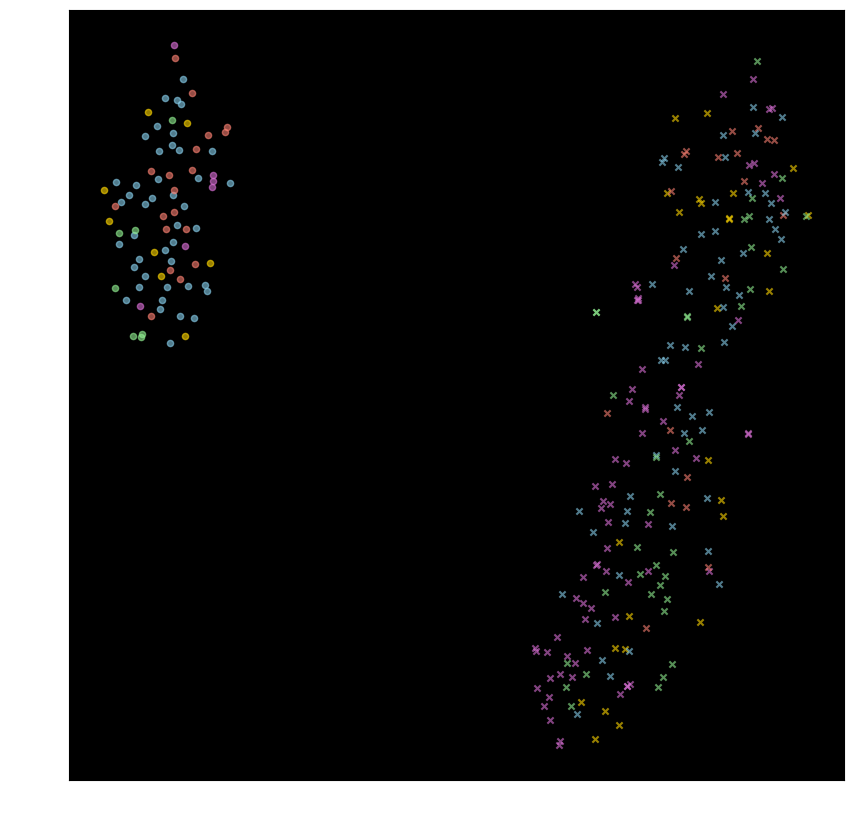

In [43]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
plt.gca().set_facecolor('black')
# Adjust the color of the ticks and labels for better visibility
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Component 1', color='white')
plt.ylabel('Component 2', color='white')

plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import torch
# from sklearn.preprocessing import MinMaxScaler

# X = torch.stack(plot_data).cpu().numpy()
# labelsNums = plot_labels

# # Perform t-SNE dimensionality reduction
# X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# # Normalize the points
# scaler = MinMaxScaler()
# X_embedded_normalized = scaler.fit_transform(X_embedded)

# # Create the scatter plot
# plt.figure(figsize=(10, 10))
# for i in range(len(X_embedded_normalized)):
#     marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
#     plt.scatter(X_embedded_normalized[i, 0], X_embedded_normalized[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# # Set the background color to black
# plt.gca().set_facecolor('black')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')

# plt.show()


In [44]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [45]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [46]:
learning_rate = 1e-5
num_epochs = 200
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [ ]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [23]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 200
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter('logs/flakyXbert_300_seed123456')
epoch_loss_list = []
for epoch in range(num_epochs):
    total_loss = 0.01
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_dataloader) + i)
        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'flakyXbert_augExp2.pth')
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

2024-06-21 14:30:21.882831: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 14:30:21.897362: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 14:30:21.897380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 14:30:21.897393: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-21 14:30:21.900806: I tensorflow/core/platform/cpu_feature_g

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 1/200, Loss: 1.2389910046474353


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 2/200, Loss: 0.9305796351948299


  3%|▎         | 1/37 [00:00<00:17,  2.08it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 3/200, Loss: 0.9530432919553807


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 4/200, Loss: 0.8990808518512828


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 5/200, Loss: 0.9057033169269562


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 6/200, Loss: 0.9334759247625196


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 7/200, Loss: 0.9231551984838536


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 8/200, Loss: 0.9336147375364561


  3%|▎         | 1/37 [00:00<00:16,  2.23it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 9/200, Loss: 0.8547874659460943


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 10/200, Loss: 0.8817342522337629


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 11/200, Loss: 0.8583108906165973


  3%|▎         | 1/37 [00:00<00:16,  2.23it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 12/200, Loss: 0.8484197873682588


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 13/200, Loss: 0.8357343603791417


100%|██████████| 37/37 [00:13<00:00,  2.82it/s]


Epoch 14/200, Loss: 0.8339990057816375


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 15/200, Loss: 0.8246731438507904


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 16/200, Loss: 0.7481192111324619


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 17/200, Loss: 0.796899523541734


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 18/200, Loss: 0.8121885023568127


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 19/200, Loss: 0.7446262234932667


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 20/200, Loss: 0.7365877816161593


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 21/200, Loss: 0.7082080976544199


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 22/200, Loss: 0.7112595731503254


  3%|▎         | 1/37 [00:00<00:16,  2.19it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 23/200, Loss: 0.6822711666854652


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 24/200, Loss: 0.6503012819225723


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 25/200, Loss: 0.6858515137917286


  3%|▎         | 1/37 [00:00<00:09,  3.71it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 26/200, Loss: 0.7006655849476118


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 27/200, Loss: 0.617757378655511


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 28/200, Loss: 0.7308018477945714


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 29/200, Loss: 0.6869348954671137


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 30/200, Loss: 0.6042859500485497


  3%|▎         | 1/37 [00:00<00:12,  2.82it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 31/200, Loss: 0.5735321949623726


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 32/200, Loss: 0.659185539484024


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 33/200, Loss: 0.5693792067025158


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 34/200, Loss: 0.5453601453916446


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 35/200, Loss: 0.506729045687495


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 36/200, Loss: 0.5441468706968667


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 37/200, Loss: 0.5556097856808353


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 38/200, Loss: 0.5972904493035497


100%|██████████| 37/37 [00:13<00:00,  2.76it/s]


Epoch 39/200, Loss: 0.42273405320741037


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 40/200, Loss: 0.46446484051040693


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 41/200, Loss: 0.48877532242117694


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 42/200, Loss: 0.497811119757794


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 43/200, Loss: 0.5201636486923372


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 44/200, Loss: 0.48048262706479505


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 45/200, Loss: 0.4955393332242965


  3%|▎         | 1/37 [00:00<00:12,  2.84it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 46/200, Loss: 0.5081290327374999


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 47/200, Loss: 0.4378321990934578


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 48/200, Loss: 0.4592783536218308


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 49/200, Loss: 0.4082490268752382


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 50/200, Loss: 0.4742677520416878


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 51/200, Loss: 0.42968012096108615


  3%|▎         | 1/37 [00:00<00:18,  1.90it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 52/200, Loss: 0.5005211113836314


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 53/200, Loss: 0.4635198523627745


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 54/200, Loss: 0.3738129197906803


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 55/200, Loss: 0.4456467916997703


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 56/200, Loss: 0.43670532958733066


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 57/200, Loss: 0.3965195119944779


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 58/200, Loss: 0.5025993940556371


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 59/200, Loss: 0.4202089437117448


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 60/200, Loss: 0.36403459598083754


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 61/200, Loss: 0.4498454773909336


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 62/200, Loss: 0.37057569145350844


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 63/200, Loss: 0.417578750421872


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 64/200, Loss: 0.34953613000947076


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 65/200, Loss: 0.3821049784244718


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 66/200, Loss: 0.4309818864029807


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 67/200, Loss: 0.3542425020884823


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 68/200, Loss: 0.3430267454160226


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 69/200, Loss: 0.39806631454744856


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 70/200, Loss: 0.38937905839166126


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 71/200, Loss: 0.3589821885324813


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 72/200, Loss: 0.31735881927045617


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 73/200, Loss: 0.36731996251924615


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 74/200, Loss: 0.3224903478574108


  3%|▎         | 1/37 [00:00<00:14,  2.52it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 75/200, Loss: 0.2577089635665352


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 76/200, Loss: 0.3099716461349178


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 77/200, Loss: 0.36714057972302305


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 78/200, Loss: 0.2693616311453484


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 79/200, Loss: 0.3378718252782081


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 80/200, Loss: 0.3170001769146404


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 81/200, Loss: 0.2944831264743934


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 82/200, Loss: 0.25343723097363036


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 83/200, Loss: 0.33918753050469064


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 84/200, Loss: 0.3660124522769773


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 85/200, Loss: 0.3391025902612789


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 86/200, Loss: 0.30921037379954314


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 87/200, Loss: 0.3852650656651806


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 88/200, Loss: 0.29028080026845676


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 89/200, Loss: 0.23751728202040132


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 90/200, Loss: 0.30356354413000314


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 91/200, Loss: 0.288522954381801


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 92/200, Loss: 0.22261805576247137


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 93/200, Loss: 0.27612921742168633


100%|██████████| 37/37 [00:13<00:00,  2.74it/s]


Epoch 94/200, Loss: 0.31312917762511483


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 95/200, Loss: 0.27349633024351017


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 96/200, Loss: 0.2751170951128006


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 97/200, Loss: 0.33161429381853824


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 98/200, Loss: 0.28218993288439675


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 99/200, Loss: 0.2924179173562978


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 100/200, Loss: 0.2553482215307854


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 101/200, Loss: 0.2767154798475472


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 102/200, Loss: 0.29174576765782123


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 103/200, Loss: 0.2804685372516916


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 104/200, Loss: 0.2430491041251131


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 105/200, Loss: 0.2638060616238697


  3%|▎         | 1/37 [00:00<00:09,  3.69it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 106/200, Loss: 0.3023555696171683


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 107/200, Loss: 0.22341465955650483


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 108/200, Loss: 0.2657149293696558


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 109/200, Loss: 0.2354242654665801


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 110/200, Loss: 0.2777082429302705


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 111/200, Loss: 0.3110702557902078


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 112/200, Loss: 0.2271203755688023


  3%|▎         | 1/37 [00:00<00:11,  3.16it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 113/200, Loss: 0.2884360117445121


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 114/200, Loss: 0.2291345357250523


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 115/200, Loss: 0.27106510591668054


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 116/200, Loss: 0.2042807840576043


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 117/200, Loss: 0.2643619494422062


  3%|▎         | 1/37 [00:00<00:12,  2.95it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 118/200, Loss: 0.1984510756586049


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 119/200, Loss: 0.20703124940193987


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 120/200, Loss: 0.20407314000097482


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 121/200, Loss: 0.18090370282933518


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 122/200, Loss: 0.19836456434952246


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 123/200, Loss: 0.21785093366294292


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 124/200, Loss: 0.2133338911066184


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 125/200, Loss: 0.2044176526327391


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 126/200, Loss: 0.18675257955854002


100%|██████████| 37/37 [00:13<00:00,  2.81it/s]


Epoch 127/200, Loss: 0.23025068384570044


  3%|▎         | 1/37 [00:00<00:13,  2.61it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 128/200, Loss: 0.21210592124913188


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 129/200, Loss: 0.20797752644967388


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 130/200, Loss: 0.1764182273761646


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 131/200, Loss: 0.20811611218226922


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 132/200, Loss: 0.24709045691264642


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 133/200, Loss: 0.20120131813996547


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 134/200, Loss: 0.20986080719007028


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 135/200, Loss: 0.21273406258305988


  3%|▎         | 1/37 [00:00<00:11,  3.17it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 136/200, Loss: 0.21456939088331686


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 137/200, Loss: 0.2321438093201534


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 138/200, Loss: 0.27964691138750797


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 139/200, Loss: 0.21430048130654


  3%|▎         | 1/37 [00:00<00:11,  3.10it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 140/200, Loss: 0.19316209576419882


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 141/200, Loss: 0.1776883753731444


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 142/200, Loss: 0.19458810849769695


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 143/200, Loss: 0.22162624011168608


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 144/200, Loss: 0.1799009305963645


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 145/200, Loss: 0.2237645851357563


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 146/200, Loss: 0.18650469109013273


  3%|▎         | 1/37 [00:00<00:13,  2.72it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 147/200, Loss: 0.20271450608968733


  3%|▎         | 1/37 [00:00<00:19,  1.82it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 148/200, Loss: 0.19353813361477207


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 149/200, Loss: 0.22907917428661037


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 150/200, Loss: 0.15592806489886463


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 151/200, Loss: 0.15377275450004113


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 152/200, Loss: 0.22601171185841432


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 153/200, Loss: 0.14279470699058996


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 154/200, Loss: 0.14752840538282652


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 155/200, Loss: 0.18702353857356954


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 156/200, Loss: 0.18356105690872346


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 157/200, Loss: 0.19208584952998806


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 158/200, Loss: 0.1525345413024361


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 159/200, Loss: 0.19248416562338133


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 160/200, Loss: 0.22024156360207375


  3%|▎         | 1/37 [00:00<00:17,  2.10it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.67it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 161/200, Loss: 0.1306575051997159


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 162/200, Loss: 0.15072307298312315


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 163/200, Loss: 0.13191885849108567


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 164/200, Loss: 0.23167472982728804


100%|██████████| 37/37 [00:13<00:00,  2.79it/s]


Epoch 165/200, Loss: 0.1822998786053142


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 166/200, Loss: 0.1584913350601454


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 167/200, Loss: 0.15277437025630797


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 168/200, Loss: 0.14741493142939902


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 169/200, Loss: 0.13782599775372323


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 170/200, Loss: 0.20467330843210219


  3%|▎         | 1/37 [00:00<00:24,  1.47it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 171/200, Loss: 0.14817344805678806


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 172/200, Loss: 0.1425497039105441


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 173/200, Loss: 0.14395642688950977


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 174/200, Loss: 0.1666257239032436


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 175/200, Loss: 0.1762410014223408


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 176/200, Loss: 0.157638110075448


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 177/200, Loss: 0.1595820843529057


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 178/200, Loss: 0.14274397477910325


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 179/200, Loss: 0.22359431862831114


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 180/200, Loss: 0.21040278598263457


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 181/200, Loss: 0.19554036096141145


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 182/200, Loss: 0.14134624303998172


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 183/200, Loss: 0.15847780037570644


100%|██████████| 37/37 [00:13<00:00,  2.72it/s]


Epoch 184/200, Loss: 0.14794627421611065


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 185/200, Loss: 0.1488913112959346


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 186/200, Loss: 0.15574356899068162


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 187/200, Loss: 0.13318649523967022


  3%|▎         | 1/37 [00:00<00:15,  2.36it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 188/200, Loss: 0.1693962744522739


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 189/200, Loss: 0.10946515127613737


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 190/200, Loss: 0.12720063052467398


  3%|▎         | 1/37 [00:00<00:14,  2.41it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.67it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.22it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 191/200, Loss: 0.15328148214398202


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 192/200, Loss: 0.13049350563738796


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 193/200, Loss: 0.17287755078560596


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 194/200, Loss: 0.18017237397464544


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 195/200, Loss: 0.16422256067797944


  3%|▎         | 1/37 [00:00<00:13,  2.71it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 196/200, Loss: 0.13154510494825003


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 197/200, Loss: 0.1278024604352745


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 198/200, Loss: 0.14424395929317216


  3%|▎         | 1/37 [00:00<00:17,  2.08it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 199/200, Loss: 0.1306322467246571


  3%|▎         | 1/37 [00:00<00:06,  5.19it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]

Epoch 200/200, Loss: 0.13329847746604198


In [47]:
epoch_loss_list[-20:]

['Epoch 181/200, Loss: 0.19554036096141145',
 'Epoch 182/200, Loss: 0.14134624303998172',
 'Epoch 183/200, Loss: 0.15847780037570644',
 'Epoch 184/200, Loss: 0.14794627421611065',
 'Epoch 185/200, Loss: 0.1488913112959346',
 'Epoch 186/200, Loss: 0.15574356899068162',
 'Epoch 187/200, Loss: 0.13318649523967022',
 'Epoch 188/200, Loss: 0.1693962744522739',
 'Epoch 189/200, Loss: 0.10946515127613737',
 'Epoch 190/200, Loss: 0.12720063052467398',
 'Epoch 191/200, Loss: 0.15328148214398202',
 'Epoch 192/200, Loss: 0.13049350563738796',
 'Epoch 193/200, Loss: 0.17287755078560596',
 'Epoch 194/200, Loss: 0.18017237397464544',
 'Epoch 195/200, Loss: 0.16422256067797944',
 'Epoch 196/200, Loss: 0.13154510494825003',
 'Epoch 197/200, Loss: 0.1278024604352745',
 'Epoch 198/200, Loss: 0.14424395929317216',
 'Epoch 199/200, Loss: 0.1306322467246571',
 'Epoch 200/200, Loss: 0.13329847746604198']

In [ ]:
# torch.save(siamese_network.state_dict(), 'linear_randomL2_NoOverlap_01.pth')

In [48]:
siamese_network.load_state_dict(torch.load('flakyXbert_augExp2.pth'))


<All keys matched successfully>

In [49]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 295/295 [00:12<00:00, 23.94it/s]


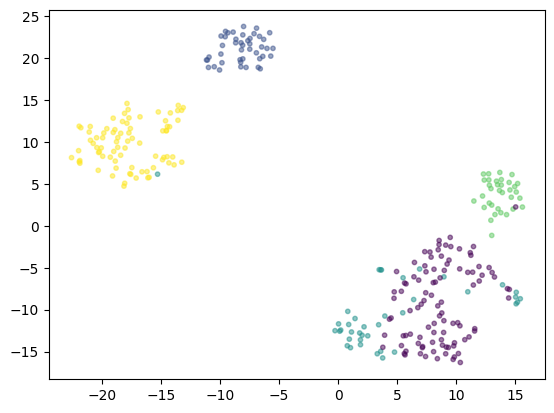

In [50]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.5 )


In [51]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=3402, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [52]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 5
    for label in range(5):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [53]:
int_to_label={
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [54]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

unordered collections
test order dependency


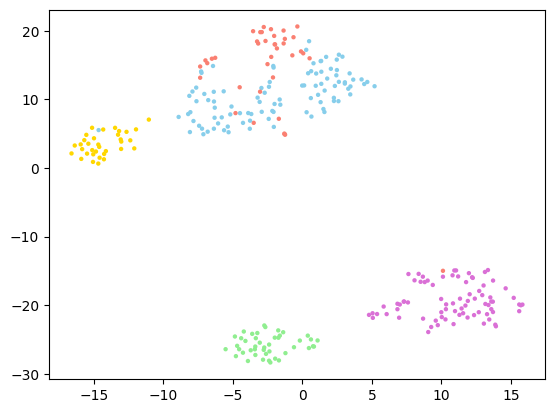

In [55]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# previous best result learing rate: 1e-5
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Scatter plot
for i, label in enumerate(labelsNums[:len(X_embedded)]):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
# legend_labels = list(shortened_labels.values())  # Use shortened labels for legend
# plt.legend(labels=legend_labels)

plt.show()


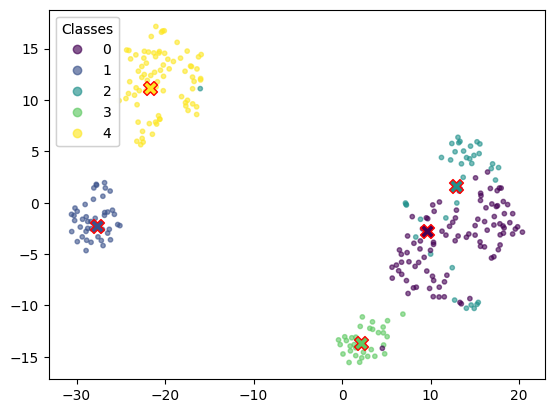

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [ ]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# # Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# # Silhouette Score:
# # - Measures how similar an object is to its own cluster compared to other clusters.
# # - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
# #   A score close to 1 means that the clusters are well separated and clearly defined.
# silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Silhouette Score: {silhouette_avg}")

# # Davies-Bouldin Index:
# # - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
# #   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# # - Range: 0 to +∞. Lower scores indicate better clustering quality.
# davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Davies-Bouldin Index: {davies_bouldin}")

# # Calinski-Harabasz Index:
# # - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# # - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
# calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Calinski-Harabasz Index: {calinski_harabasz}")


In [57]:
    from sklearn.metrics import f1_score

    int_to_label={
        0: 'async wait',
        1: 'unordered collections',
        2: 'concurrency',
        3: 'time',
        4: 'test order dependency'
    }
    count = 0

    # Assuming val_dataset is iterable and has 'anchor' and 'label' keys
    predicted_labels = []
    true_labels = []

    for item in val_dataset:
        count+=1
        input_vector = item['anchor']  # Your input vector for prediction
        predicted_label = predict(input_vector)  # Get predicted cluster/label
        predicted_labels.append(predicted_label)
        
        true_label = item['label']  # True label
        true_label = int_to_label[int(true_label)]
        true_labels.append(true_label)
        print(count, " ",predicted_label, " " ,true_label)
    # Convert predicted labels to the same format as true_labels if necessary
    # This might include converting cluster IDs to the label format, depending on how your `predict` function outputs the prediction

    # Note: Ensure that your predict function returns labels in a format that matches true_labels or adjust accordingly
    print("loop completed")
    # Calculate F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Adjust 'average' as necessary
    print(f"F1 Score: {f1}")


1   test order dependency   test order dependency
2   time   test order dependency
3   test order dependency   test order dependency
4   test order dependency   test order dependency
5   test order dependency   test order dependency
6   test order dependency   test order dependency
7   async wait   time
8   async wait   time
9   unordered collections   time
10   unordered collections   time
11   test order dependency   test order dependency
12   async wait   test order dependency
13   test order dependency   test order dependency
14   test order dependency   test order dependency
15   concurrency   async wait
16   async wait   async wait
17   async wait   async wait
18   async wait   async wait
19   test order dependency   test order dependency
20   test order dependency   test order dependency
21   concurrency   concurrency
22   concurrency   concurrency
23   unordered collections   unordered collections
24   unordered collections   unordered collections
25   async wait   async wait
2

                       precision    recall  f1-score   support

           async wait       0.72      0.67      0.69       251
          concurrency       0.46      0.60      0.52        96
test order dependency       0.89      0.74      0.81       188
                 time       0.64      0.76      0.69        80
unordered collections       0.87      0.90      0.88       102

             accuracy                           0.72       717
            macro avg       0.71      0.73      0.72       717
         weighted avg       0.74      0.72      0.73       717


 - Accuracy :  0.72
 - Precision :  0.74
 - Recall :  0.72
 - F1 score :  0.73
 - MCC :  0.64
 - AUC :  0.82


Perfomnaces by categories



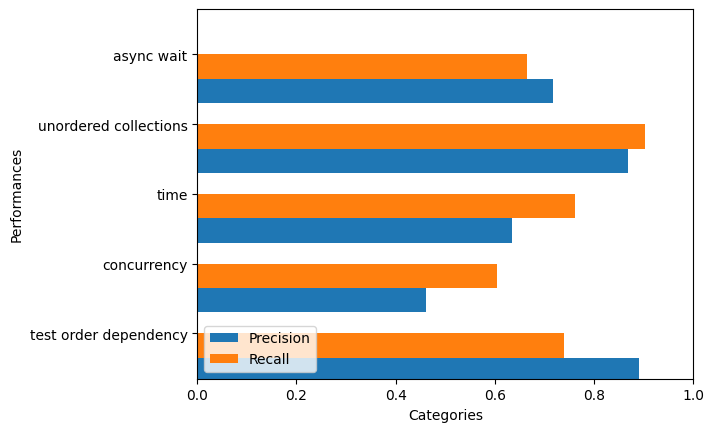



Confusion Matrix 


<AxesSubplot:>

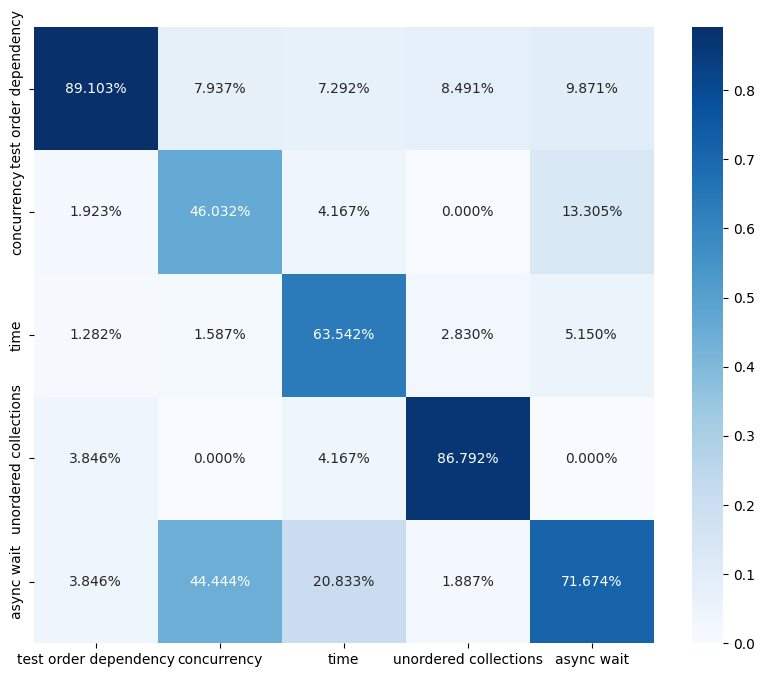

In [58]:
%matplotlib inline
warnings.filterwarnings("ignore")
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


predicted = predicted_labels
labels = true_labels
unique_labels = list ( set(labels ) )
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

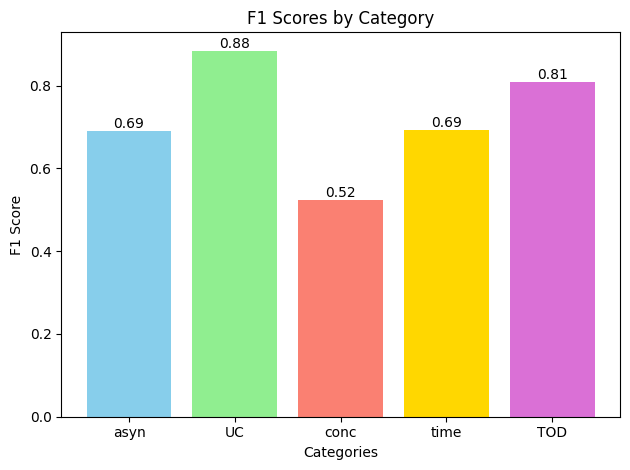

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
int_to_label = {
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}

# Shortened category names
shortened_labels = {
    'async wait': 'asyn',
    'unordered collections': 'UC',
    'concurrency': 'conc',
    'time': 'time',
    'test order dependency': 'TOD'
}

# Convert true and predicted labels back to integers for F1 score calculation
true_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in true_labels]
predicted_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in predicted_labels]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.values())
for category in categories:
    true_bin = [1 if label == category else 0 for label in true_labels]
    pred_bin = [1 if label == category else 0 for label in predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[category] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# file_path = 'test_data_predictions.csv'

# # Load the compressed CSV file into a DataFrame
# df = pd.read_csv(file_path)

# # Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
# labels_flaky = df['TrueLabel'].tolist()
# predicted_flaky = df['PredictedLabel'].tolist()

# print (classification_report(labels, predicted))

# print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
# print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
# print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

# print("\n\nPerfomnaces by categories\n")


# ind = np.arange(len(unique_labels)) 
# width = 0.35
# fig, ax = plt.subplots()
# precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
# recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
# ax.barh(ind - width/2, precision, width, label='Precision')
# ax.barh(ind + width/2, recall, width, label='Recall')
# ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
# ylim=[2*width - 1, len(ind)])
# plt.xlim(0,1)
# ax.legend(loc='upper right')
# ax.set_xlabel("Performances")
# ax.set_ylabel("Categories")
# plt.show()

# print("\n\nConfusion Matrix ")

# mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
# df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
# plt.figure(figsize = (10,8))
# sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
# recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# # And assuming 'unique_labels' is defined as before

# ind = np.arange(len(unique_labels))  # the x locations for the groups
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# # Using a set of contrasting, darker colors
# colors = ['blue', 'green', 'red', 'orange']

# # Plotting Precision and Recall for Your Model
# rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
# rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# # Plotting Precision and Recall for Flaky Model
# rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
# rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# # Optional: Adding scores above bars
# ax.bar_label(rects1, padding=3, fmt='%.2f')
# ax.bar_label(rects2, padding=3, fmt='%.2f')
# ax.bar_label(rects3, padding=3, fmt='%.2f')
# ax.bar_label(rects4, padding=3, fmt='%.2f')

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming metrics have been calculated and stored in variables for both models.
# # Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# # And similarly named variables with a '_flaky' suffix for the comparison model.

# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
# your_model_metrics = [
#     np.round(metrics.accuracy_score(labels, predicted), 2),
#     np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels, predicted), 2),
#     np.round(multiclass_roc_auc_score(labels, predicted), 2)
# ]

# flaky_model_metrics = [
#     np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
#     np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
#     np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
# ]

# x = np.arange(len(metrics_labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
# rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def extract_projections(siamese_network, dataloader):
    projections = []
    labels = []
    for batch in dataloader:
        label = batch["label"]
        anchor = batch["anchor"]
        projection = siamese_network(anchor)
        
        projections.append(projection.cpu().detach().numpy())
        labels.append(label.numpy())
    projections = np.vstack(projections)
    labels = np.hstack(labels)
    return projections, labels

In [ ]:
projections, labels = extract_projections(siamese_network, train_dataloader)
val_projections, val_labels = extract_projections(siamese_network, val_dataloader)

In [ ]:
print(len(projections), len(train_dataloader))

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(projections, labels)

# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(projections, labels)

In [ ]:
# Evaluate Random Forest Classifier
rf_predictions = rf_classifier.predict(val_projections)
rf_accuracy = accuracy_score(val_labels, rf_predictions)
rf_f1 = f1_score(val_labels, rf_predictions, average='weighted')
print(f"Random Forest Classifier Accuracy: {rf_accuracy}, F1: {rf_f1}")

# Evaluate SVM Classifier
svm_predictions = svm_classifier.predict(val_projections)
svm_accuracy = accuracy_score(val_labels, svm_predictions)
svm_f1 = f1_score(val_labels, svm_predictions, average='weighted')
print(f"SVM Classifier Accuracy: {svm_accuracy}, F1:{svm_f1}")